## ch1

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.09.09 </div>
<div style="text-align: right\"> Last update: 2022.09.09</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [23]:
import FinanceDataReader as fdr

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [3]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

### 1. 시계열 데이터 예시

In [4]:
def plot_single_ts(df, x, y, title = '', xlabel = 'Date', ylabel = 'Value', color = 'tab:red'):
    plt.figure(figsize = (14, 5))
    plt.plot(x, y, color = color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

#### 1.1 Air passengers dataset

In [6]:
air = pd.read_csv('https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv')
air['Month'] = pd.to_datetime(air['Month'])

In [7]:
air.head()

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


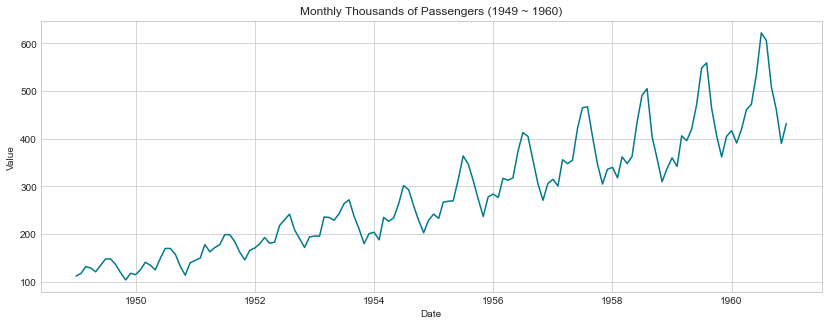

In [10]:
plot_single_ts(air, x = air.Month, y = air['Thousands of Passengers'], color=colors[0],
       title= 'Monthly Thousands of Passengers (1949 ~ 1960)')

#### 1.2 Sunspots dataset

In [14]:
sunspots = pd.read_csv('https://raw.githubusercontent.com/sguys99/datasets/master/sunspots.csv')
sunspots['Month'] = pd.to_datetime(sunspots['Month'])

In [17]:
sunspots.head()

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0


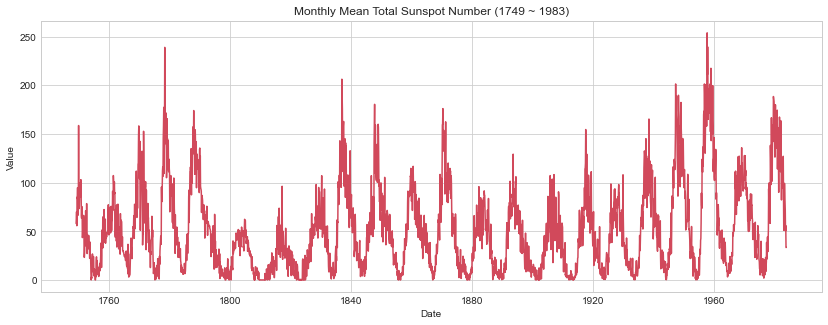

In [18]:
plot_single_ts(sunspots, x = sunspots.Month, y = sunspots.Sunspots, color=colors[1],
       title= 'Monthly Mean Total Sunspot Number (1749 ~ 1983)')

#### 1.3 Bearing sensor dataset

In [20]:
def plot_multi_ts(df, x, y, title = '', xlabel = 'Date', ylabel = 'Value', color = 'tab:red'):
    fig, ax = plt.subplots(figsize = (15, 5))
    df.set_index(x).plot(ax=ax, color=color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [21]:
sensors = pd.read_csv('https://raw.githubusercontent.com/sguys99/datasets/master/bearing_sensor_data.csv', 
                      index_col=0)
sensors = sensors.reset_index().rename(columns={'index':'timestamp'})
sensors.set_index('timestamp').head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
timestamp,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


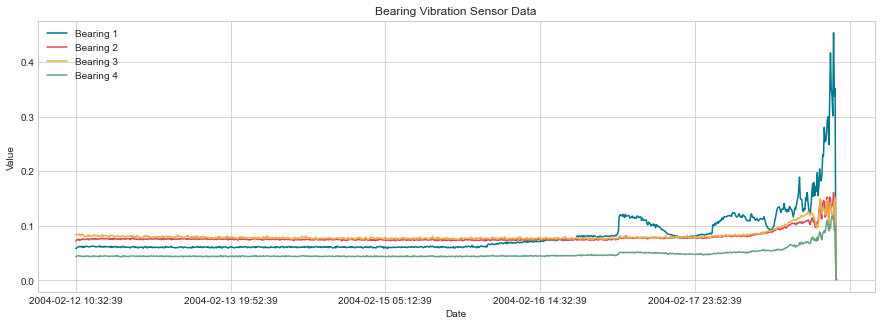

In [22]:
plot_multi_ts(sensors, x = sensors.timestamp, y = sensors.iloc[:, 1:], color=colors,
              title= 'Bearing Vibration Sensor Data')

#### 1.4 Stock market dataset

In [24]:
# 한국거래소 상장종목 전체
df_krx = fdr.StockListing('KRX')
# 삼성 티커
ss_ticker = df_krx[df_krx.Name=='삼성전자']['Symbol'] 
print(ss_ticker) #005930

4277    005930
Name: Symbol, dtype: object


In [25]:
stock = fdr.DataReader('005930','2015-01-01', '2021-07-31')
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,26799,26799,26540,26600,175499,0.002261
2015-01-05,26720,26720,26260,26660,202790,0.002256
2015-01-06,26300,26340,25760,25900,304710,-0.028507
2015-01-07,25880,26220,25640,26140,286455,0.009266
2015-01-08,26780,26780,26199,26280,289552,0.005356


종가

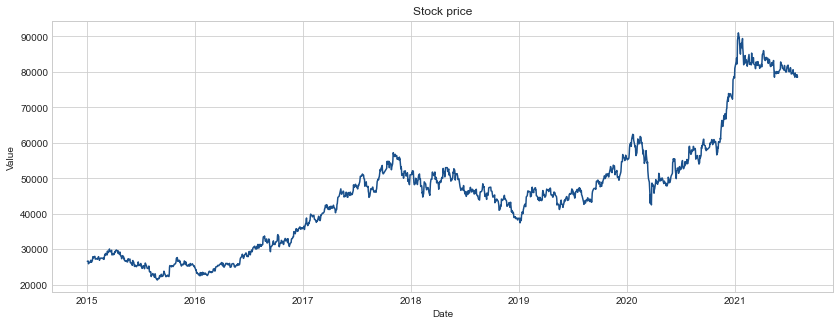

In [26]:
plot_single_ts(stock, x = stock.index, y = stock['Close'], color=colors[5],
       title= 'Stock price')

주가 변동

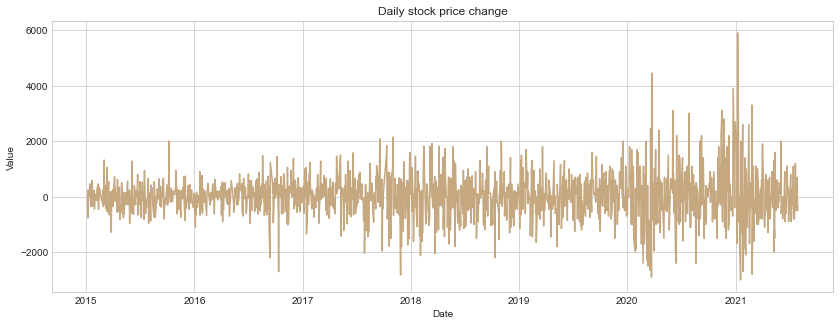

In [27]:
stock['diff'] = stock['Close'].diff(1)

plot_single_ts(stock, x = stock.index, y = stock['diff'], color=colors[7],
       title= 'Daily stock price change')

### 2. Time series decompositoion

트렌드($T_{t}$), 계절성($S_{t}$), 잔차($R_{t}$)

#### 2.1 Additive model
$y_{t}$ = $T_{t}$ + $S_{t}$ + $R_{t}$

In [32]:
air = pd.read_csv('https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv', 
                 parse_dates = ['Month'], index_col = 'Month')

In [30]:
result_add = seasonal_decompose(air['Thousands of Passengers'], 
                                model='additive', extrapolate_trend='freq')

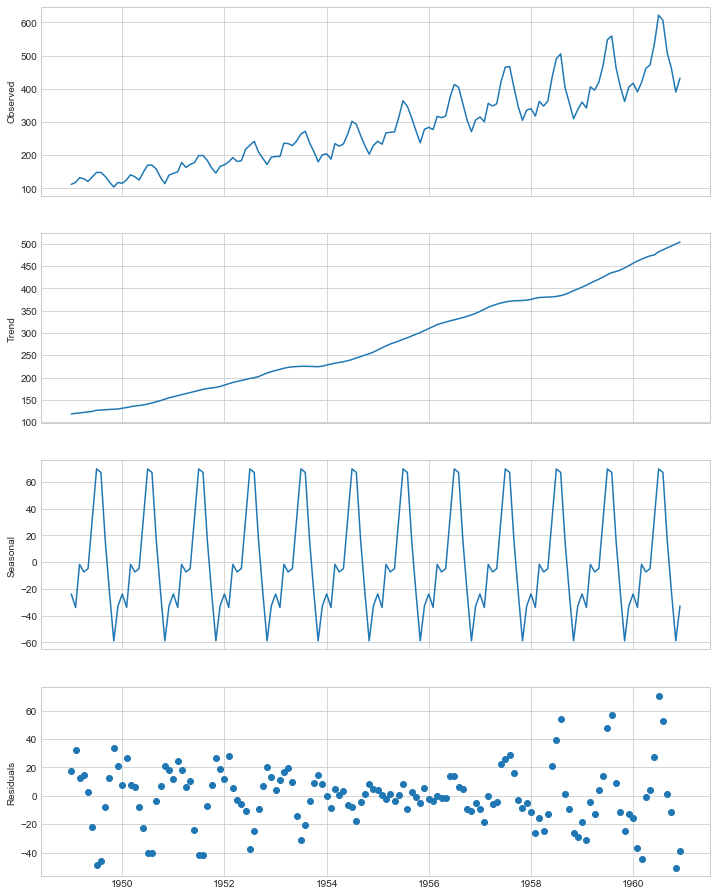

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,16))

ax1.plot(result_add.observed)
ax1.set_ylabel('Observed')

ax2.plot(result_add.trend)
ax2.set_ylabel('Trend')

ax3.plot(result_add.seasonal)
ax3.set_ylabel('Seasonal')

ax4.scatter(air.index,result_add.resid)
ax4.set_ylabel('Residuals')

#plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.show()

#### 2.2 Multicative model
$y_{t}$ = $T_{t}$ X $S_{t}$ X $R_{t}$

In [33]:
result_mul = seasonal_decompose(air['Thousands of Passengers'], 
                                model='multicative', extrapolate_trend='freq')

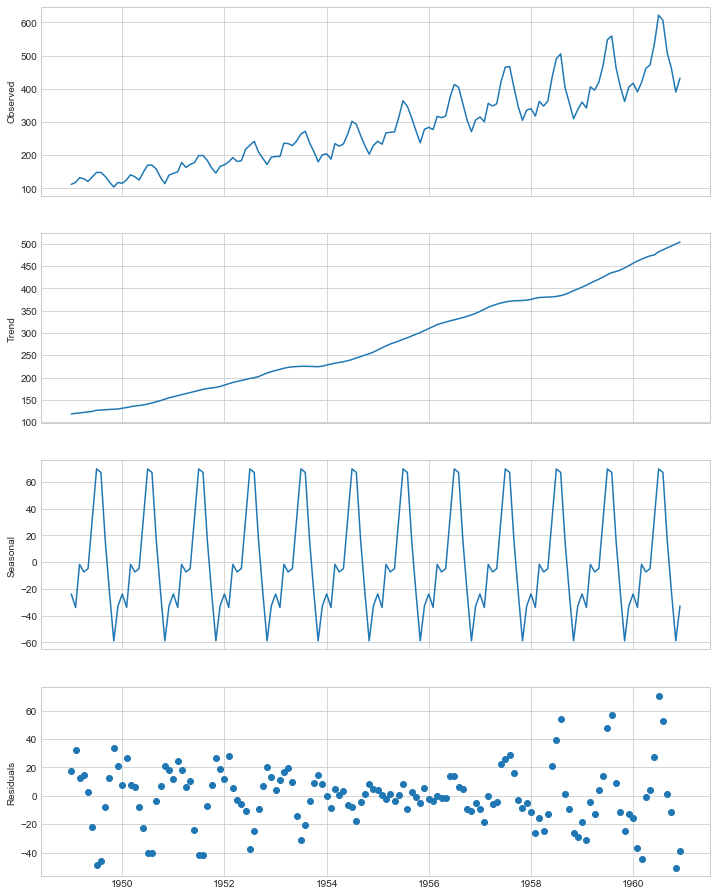

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,16))

ax1.plot(result_add.observed)
ax1.set_ylabel('Observed')

ax2.plot(result_add.trend)
ax2.set_ylabel('Trend')

ax3.plot(result_add.seasonal)
ax3.set_ylabel('Seasonal')

ax4.scatter(air.index,result_add.resid)
ax4.set_ylabel('Residuals')

#plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.show()

### 3. Stationary vs Non-statinary

#### 3.1 intuitive method

In [35]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []
    
    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))
    
    return mean_func

In [36]:
def var_over_time(process: np.array) -> np.array:
    var_func = []
    
    for i in range(len(process)):
        var_func.append(np.var(process[:i]))
    
    return var_func

In [37]:
stationary_mean = mean_over_time(stock['diff'])
non_stationary_mean = mean_over_time(stock['Close'])

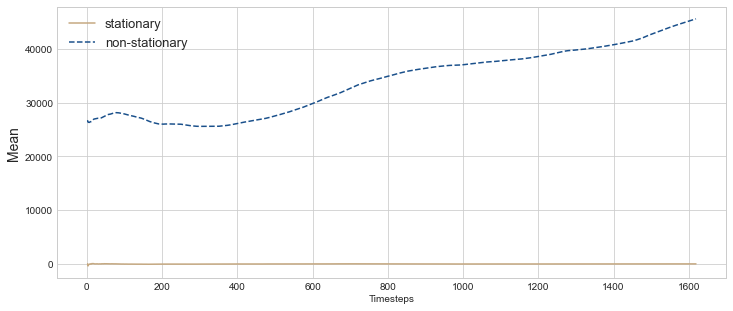

In [38]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.plot(stationary_mean, label='stationary', color = colors[7])
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary', color = colors[5])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean', fontsize=14)
ax.legend(fontsize = 13)

In [39]:
stationary_var = var_over_time(stock['diff'])
non_stationary_var = var_over_time(stock['Close'])

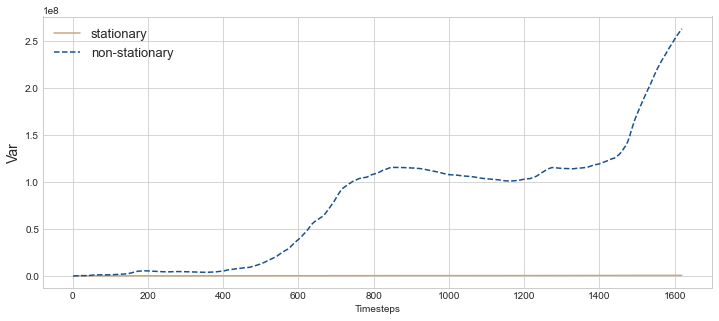

In [40]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.plot(stationary_var, label='stationary', color = colors[7])
ax.plot(non_stationary_var, linestyle='--', label='non-stationary', color = colors[5])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Var', fontsize=14)
ax.legend(fontsize = 13)

#### 3.2 Analytical method

In [42]:
ADF_result = adfuller(stock['Close'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.3614100119662256
p-value: 0.9163452856274794


In [43]:
ADF_result = adfuller(stock.loc['2015-01-05':, 'diff'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.735743654278195
p-value: 3.1038780719080016e-14


### 4. CGM Dataset

In [45]:
def load_dexcom_data(path, sampling_time='5min'):
    df = pd.read_csv(path)
    df = df[df['타임스탬프(YYYY-MM-DDThh:mm:ss)'].notnull()]
    df = df.iloc[:,[1, 7]]
    df.columns = ['timestamp', 'glucose']
    df = df.reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round(sampling_time)
    df = df.dropna()
    idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq=sampling_time)
    df = df.set_index('timestamp').reindex(idx, fill_value=np.nan).reset_index().rename(columns = {'index': 'timestamp'})
    
    return df

In [46]:
path = 'dexcom_sample.csv'

In [47]:
cgm = load_dexcom_data(path)

In [48]:
cgm.set_index('timestamp').head()

,glucose
timestamp,
2022-06-01 06:55:00,119.0
2022-06-01 07:00:00,122.0
2022-06-01 07:05:00,125.0
2022-06-01 07:10:00,128.0
2022-06-01 07:15:00,129.0


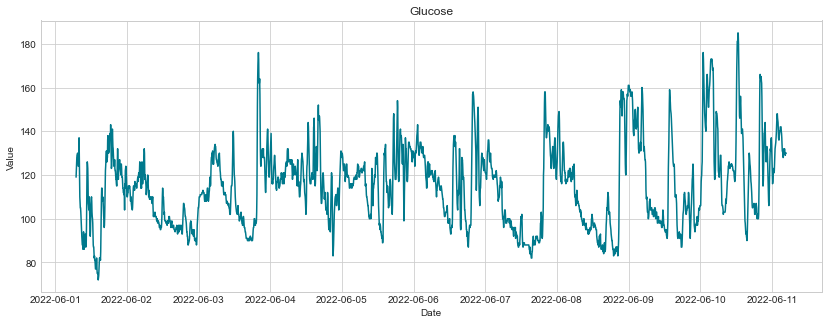

In [50]:
plot_single_ts(cgm, x = cgm['timestamp'], y = cgm['glucose'], color=colors[0],
               title= 'Glucose')

결측치 확인

In [51]:
cgm.isnull().sum()

timestamp    0
glucose      0
dtype: int64